In [1]:
import sys,os

try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *

import time
import numpy as np
import pickle

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')

# Load graph

In [2]:
# Read graph. This also supports gml and graphml format.
g = GraphLocal('./datasets/senate.graphml','graphml')

../localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



# Global graph partitioning

In [3]:
# Call the global spectral partitioning algorithm.
eig2 = fiedler(g,normalize=False)[0]

In [5]:
import scipy as sp
import scipy.sparse.linalg as splinalg

n = g.adjacency_matrix.shape[0]

D_sqrt_neg = sp.sparse.spdiags(g.dn_sqrt.transpose(), 0, n, n)

L = sp.sparse.identity(n) - D_sqrt_neg.dot((g.adjacency_matrix.dot(D_sqrt_neg)))

emb_eig_val, p = splinalg.eigsh(L, which='SM', k=2, tol = 1.0e-6)

## Compute layout for visualization

In [6]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/senate.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
#pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "./datasets/senate_pos.p", "rb" ) )

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]

## Visualization of global eigenvector on Senate

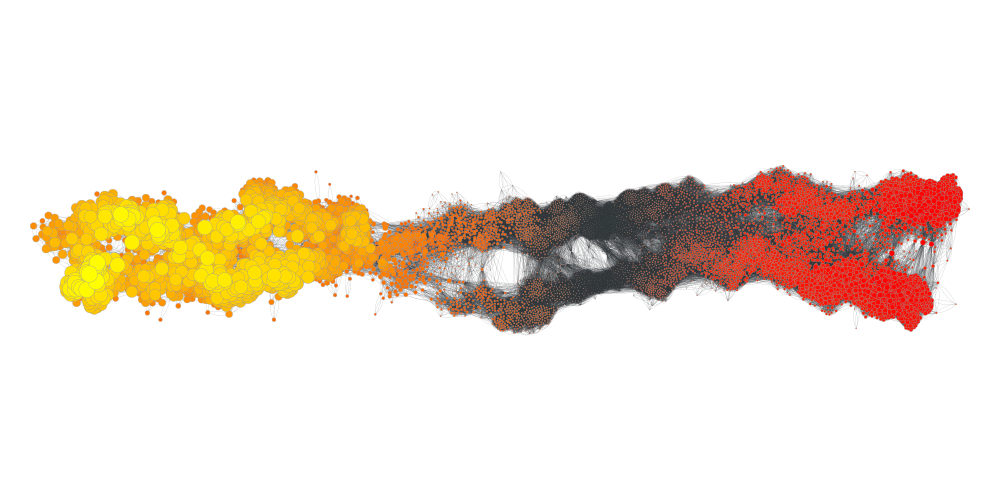

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c384208, at 0x13c384f98>

In [7]:
# Plot solutions for global eigenvector
node_weights = g_gtool.new_vertex_property("double",eig2)
node_size = g_gtool.new_vertex_property("double",np.abs(eig2)*500)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           edge_pen_width=0.1,
           vcmap=c_map)

# For exaplanation of the senate data please refer to
# K. Fountoulakis, D. Gleich and M. Mahoney, An optimization approach to locally-biased graph algorithms,
# Proceedings of the IEEE 105 (2), 256-272.

## Obtain the partition using the global eigenvector

In [8]:
# Round the eigenvector
output_sc = sweep_cut(g,eig2)

# Extract the partition for g and store it.
eig2_rounded = output_sc[0]

## Visualize the partition

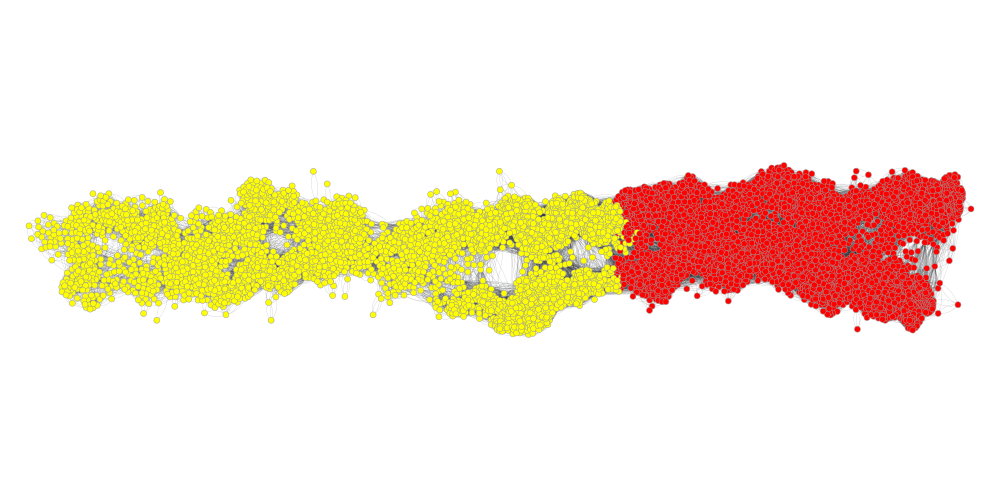

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13c384208, at 0x13c384f98>

In [9]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

eig2_rounded_c = diff(range(g._num_vertices), eig2_rounded)

temp[eig2_rounded] = 6
temp[eig2_rounded_c] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1)

## Global partitioning of John Hopkins

In [10]:
# Read John Hopkins graph.
g = GraphLocal('./datasets/JohnsHopkins.graphml','graphml','\t')

# Call the global spectral partitioning algorithm.
eig2 = fiedler(g)[0]

# Round the eigenvector
output_sc = sweep_cut(g,eig2)

# Extract the partition for g and store it.
eig2_rounded = output_sc[0]

../localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



In [11]:
eig2_rounded

array([2345, 4807, 3040, ...,   73, 1170, 4171], dtype=uint32)

## Visualize global graph partitioning of John Hopkins

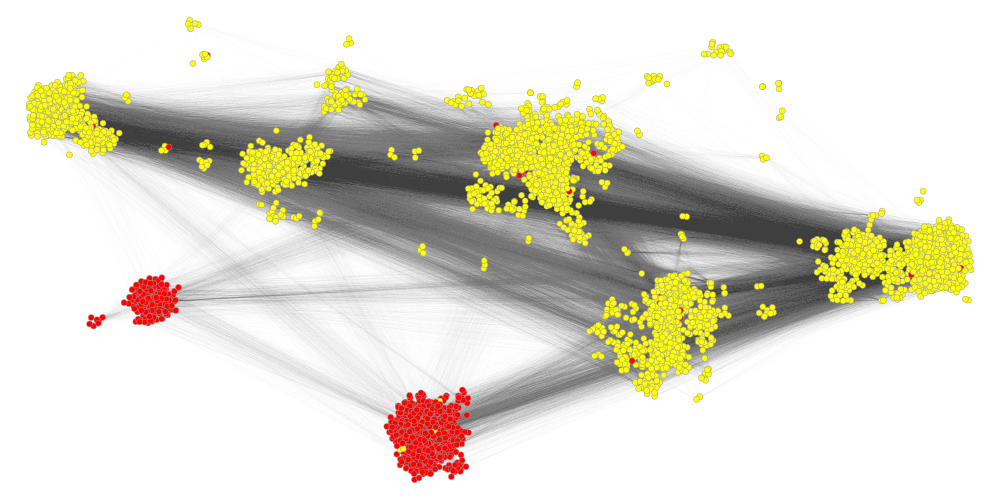

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x137fcf908, at 0x1054dbba8>

In [12]:
## Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

eig2_rounded_c = diff(range(g._num_vertices), eig2_rounded)

temp[eig2_rounded] = 6
temp[eig2_rounded_c] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in eig2_rounded:
    temp[i] = "yellow"
for i in eig2_rounded_c:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05])

## Localized vector using l1-regularized PageRank

In [13]:
# Read John Hopkins graph; a better graph than senate to demonstrate local graph clustering properties.
g = GraphLocal('./datasets/JohnsHopkins.graphml','graphml','\t')

# Find the solution of L1-regularized PageRank using localized accelerated gradient descent.
# This method is the fastest among other l1-regularized solvers and other approximate PageRank solvers.
reference_node = [2767]
l1_reg_vector = approximate_PageRank(g,reference_node,rho=5.0e-5,method="l1reg")

../localgraphclustering/GraphLocal.py:203: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load layout for John Hopkins graph

In [14]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

## Visualize localized vector for John Hopkins and reference node 2767

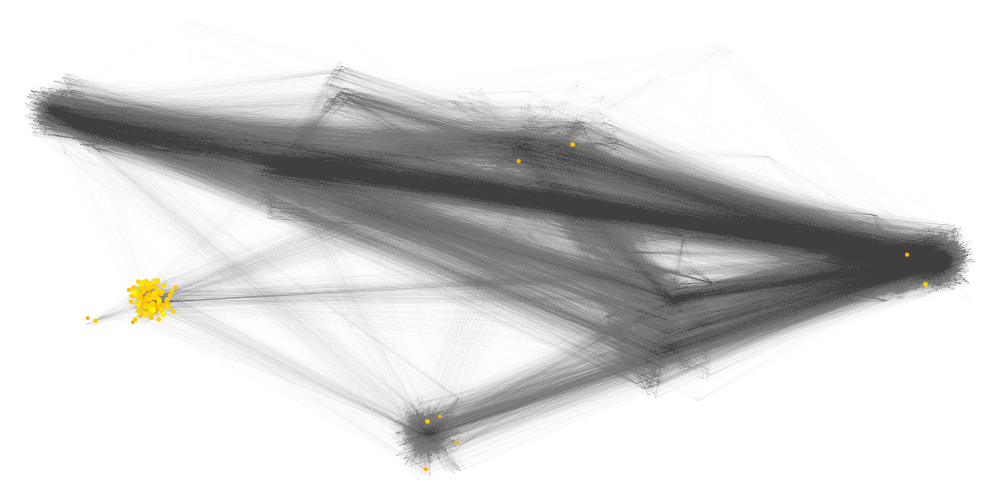

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13442a358, at 0x134427f98>

In [15]:
# Some pre-processing to make visualization better.
temp = np.zeros(g._num_vertices)
temp[l1_reg_vector[0]] = l1_reg_vector[1]
nnz_temp = temp.nonzero()
nnz_temp = nnz_temp[0]
temp[nnz_temp] = -np.log(temp[nnz_temp])
temp[nnz_temp] = 100/temp[nnz_temp]
temp = temp + 0.0001
max_all = max(temp)
temp[reference_node] = max_all/2.6
temp = temp/np.linalg.norm(temp, 2)

halo = np.zeros(g._num_vertices, dtype=bool)
halo[reference_node] = True
node_halo   = g_gtool.new_vertex_property("bool",halo)

node_weights = g_gtool.new_vertex_property("double",temp)
node_size = g_gtool.new_vertex_property("double",np.abs(temp)*50)

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, vertex_fill_color=node_weights, vorder=node_size,
           vertex_halo=node_halo,
           vertex_halo_size = 1.9,
           vertex_halo_color = "blue",
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Obtain the partition using the localized vector from l1-regularized PageRank

In [16]:
# Call C++ version of sweep cut rounding on the l1-regularized PageRank solution.
output_sc_fast = sweep_cut(g,l1_reg_vector)

# Extract the partition for g and store it.
l1_reg_vector_rounded = output_sc_fast[0]

## Visualize local partitioning of John Hopkins

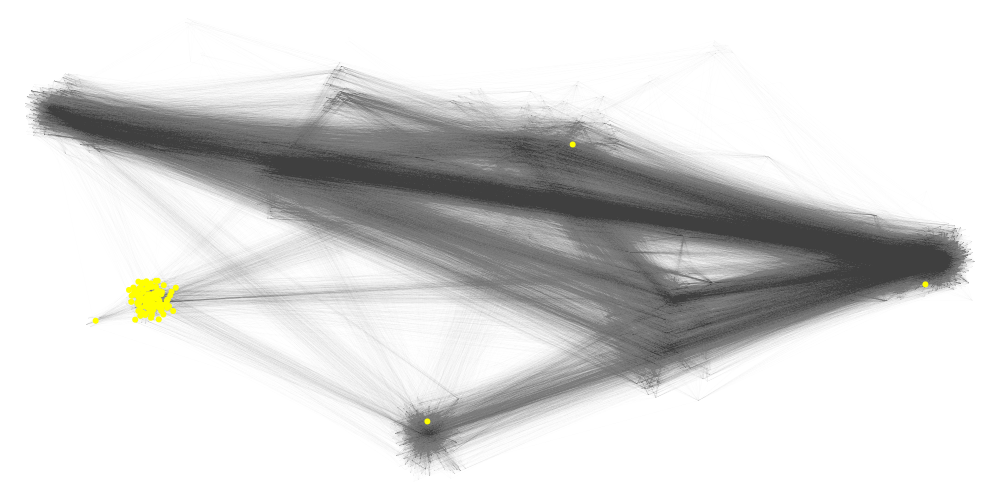

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13442a358, at 0x134427f98>

In [17]:
# Plot solutions for rounded eigenvector
temp = np.zeros(g._num_vertices) + 0.00001

temp[l1_reg_vector_rounded] = 6

node_size = g_gtool.new_vertex_property("double",temp)

temp = ["black" for x in range(g._num_vertices)]

for i in l1_reg_vector_rounded:
    temp[i] = "yellow"

node_colours = g_gtool.new_vertex_property("string",temp)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05])

## Interactive plots

In [25]:
g = GraphLocal('datasets/dolphins.smat','edgelist',' ')
ncp_instance = NCPData(g)
ncp_instance.mqi(ratio=0.5,nthreads=1)

There are  1  connected components in the graph


In [26]:
ncp_plots = NCPPlots(ncp_instance)
fig1 = ncp_plots.cond_by_vol_itrv(alpha=0.2)
fig2 = ncp_plots.cond_by_size_itrv(alpha=0.2)
fig3 = ncp_plots.isop_by_size_itrv(alpha=0.2)